In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score

/home/baylonj/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Fetch data from ucirepo, bank marketing data

# Load data

In [19]:
dataset = pd.read_csv("data/dataset.csv")

In [20]:
dataset.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,095e5d72-63d0-4c44-aba2-123aaff0f881,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,0c403949-9754-4394-b72c-61c396a3cc76,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,d8563c79-fcc0-4cdc-8d80-c871836da85c,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,43ebc39f-9a3d-41b5-a97d-4e168610ffd6,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,e6c300d4-35b9-4dc1-acb8-120959389cf0,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [18]:
# What kind of data do we have?
dataset.dtypes

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

In [21]:
# Fill nans in categorical features with 'unknown' value
dataset.fillna('unknown', inplace=True)

## Check for distributions in data

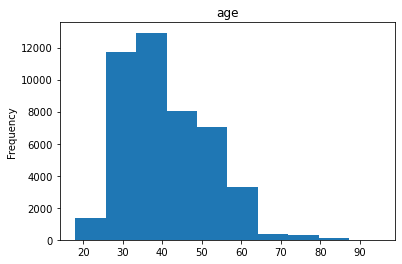

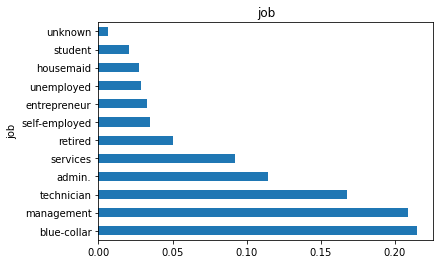

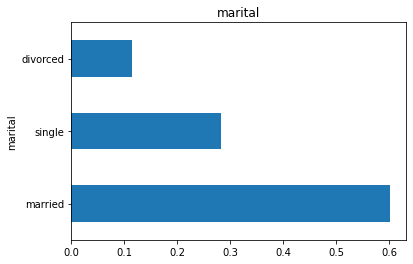

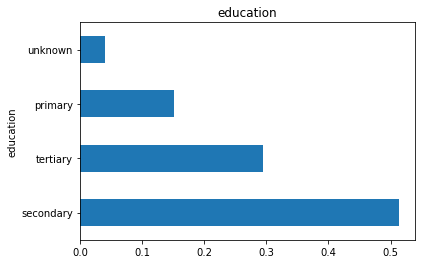

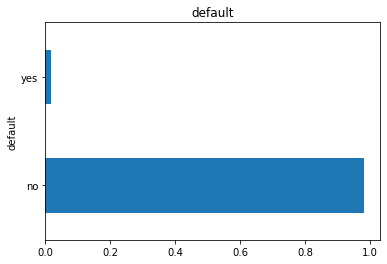

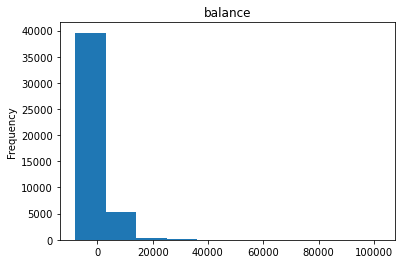

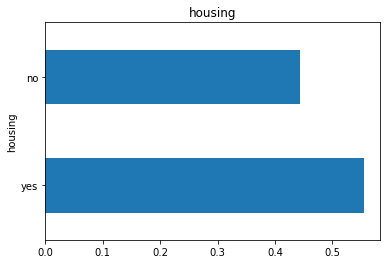

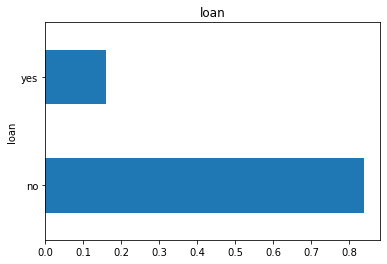

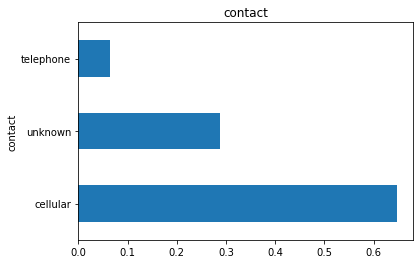

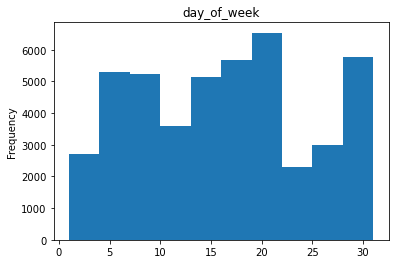

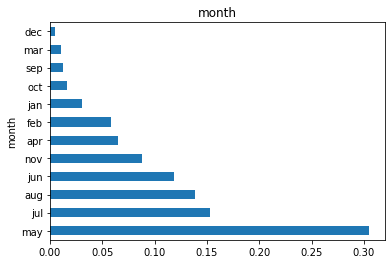

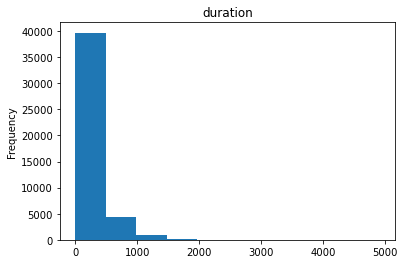

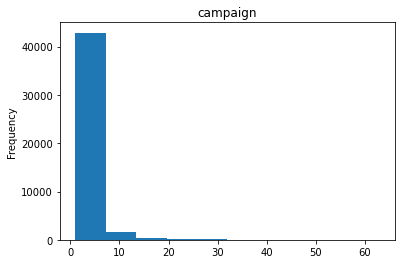

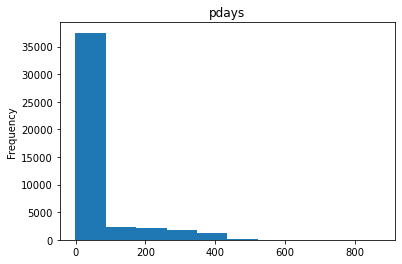

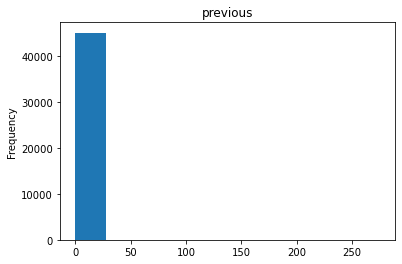

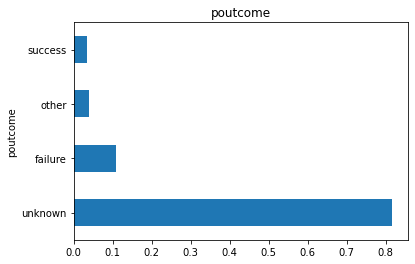

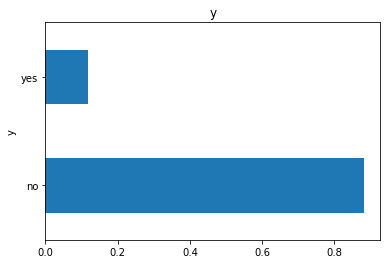

In [5]:
# Distributions
for f_ in dataset.columns:
    if dataset[f_].dtype == "object":
        plt.figure()
        dataset[f_].value_counts(normalize=True, dropna=False).plot(kind="barh", title=f_)
    else:
        plt.figure()
        dataset[f_].plot(kind="hist", bins=10, title=f_)

In [6]:
# Unbalanced data set?
dataset["y"].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

In [22]:
# Transform target feature into numerical one
dataset['y'] = dataset['y'].map({"yes":1, "no":0})

In [8]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day_of_week,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0
y,45211.0,0.116985,0.321406,0.0,0.0,0.0,0.0,1.0


## Train test split

In [23]:
MAIN_ID = "id"

NUMERICAL_FEATURES = [
    'age',
    'balance',
    'duration',
    'campaign',
    'pdays',
    'previous'
    ]

CATEGORICAL_FEATURES = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'day_of_week',
    'month',
    'poutcome'
]

TARGET_FEATURE = 'y'

In [24]:
train_df, test_df = train_test_split(dataset, test_size=0.2)

In [25]:
train_df.shape, test_df.shape

((36168, 18), (9043, 18))

In [26]:
# Proportion in training set
train_df[TARGET_FEATURE].value_counts(normalize=True)

y
0    0.884622
1    0.115378
Name: proportion, dtype: float64

In [27]:
# Proportion in test set
test_df[TARGET_FEATURE].value_counts(normalize=True)

y
0    0.87659
1    0.12341
Name: proportion, dtype: float64

In [14]:
class TargetEncodingTransformer(BaseEstimator, TransformerMixin):
    ### Uses mean of categories to encode feature the lowest the highest presence of positive category
    ### It deals with unknown categories using the maximum encoding + 1
    
    def __init__(self, categorical_features, target_feature):
        self.categorical_features = categorical_features
        self.target_feature = target_feature

    def fit(self, X, y=None):
        X_copy = X.copy()
        
        cat_dict = {}
        for cat_ in self.categorical_features:
            temp_dict = {val_:ii for ii, val_ in enumerate(X_copy.groupby(cat_)[self.target_feature].mean().sort_values(ascending=False).index)} 

            cat_dict[cat_] = temp_dict
        self.cat_dict = cat_dict
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for cat_, dict_ in self.cat_dict.items():
            X_copy[f"{cat_}_tenc"] = X_copy[cat_].map(dict_)
            ### Fill missing categories with maximum values + 1
            X_copy[f"{cat_}_tenc"] = X_copy[f"{cat_}_tenc"].fillna(max(dict_.values())+1)
        return X_copy


In [15]:
tenc_transformer = TargetEncodingTransformer(categorical_features=CATEGORICAL_FEATURES, target_feature=TARGET_FEATURE)


In [16]:
tenc_transformer.fit(train_df)

TargetEncodingTransformer(categorical_features=['job', 'marital', 'education',
                                                'default', 'housing', 'loan',
                                                'contact', 'day_of_week',
                                                'month', 'poutcome'],
                          target_feature='y')

In [17]:
tenc_transformer.transform(test_df)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,job_tenc,marital_tenc,education_tenc,default_tenc,housing_tenc,loan_tenc,contact_tenc,day_of_week_tenc,month_tenc,poutcome_tenc
556,39,services,divorced,primary,no,471,yes,no,unknown,6,...,8,1,3,0,1,0,2,22,11,3
213,36,services,married,secondary,no,301,yes,no,unknown,5,...,8,2,2,0,1,0,2,20,11,3
715,41,admin.,divorced,secondary,no,322,yes,no,unknown,6,...,5,1,2,0,1,0,2,22,11,3
19925,55,blue-collar,married,primary,no,9997,no,no,cellular,8,...,11,2,3,0,0,0,0,19,6,3
37428,37,services,married,secondary,no,1328,yes,no,telephone,13,...,8,2,2,0,1,0,1,8,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35596,51,blue-collar,married,unknown,no,0,yes,no,telephone,7,...,11,2,1,0,1,0,1,25,11,3
22927,54,blue-collar,married,primary,no,7073,no,no,cellular,26,...,11,2,3,0,0,0,0,16,6,3
29714,30,management,single,tertiary,no,179,no,no,cellular,3,...,4,0,0,0,0,0,0,4,5,3
8367,28,services,married,secondary,no,468,yes,yes,unknown,3,...,8,2,2,0,1,1,2,4,9,3


In [18]:
class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

    def fit(self, X, y=None):
    
        self.encoder.fit(X[self.categorical_features])
        self.encoded_features = self.encoder.get_feature_names_out()
    
        return self
    
    def transform(self, X):
        X_copy = X.copy()
       
        X_copy[[f"{f_}_ohenc" for f_ in self.encoded_features]] = self.encoder.transform(X_copy[self.categorical_features])
        
        return X_copy


In [19]:
ohe_trf = OneHotEncoderTransformer(categorical_features=CATEGORICAL_FEATURES)

In [20]:
ohe_trf.fit(train_df)

OneHotEncoderTransformer(categorical_features=['job', 'marital', 'education',
                                               'default', 'housing', 'loan',
                                               'contact', 'day_of_week',
                                               'month', 'poutcome'])

In [21]:
ohe_trf.transform(train_df)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,month_jun_ohenc,month_mar_ohenc,month_may_ohenc,month_nov_ohenc,month_oct_ohenc,month_sep_ohenc,poutcome_failure_ohenc,poutcome_other_ohenc,poutcome_success_ohenc,poutcome_unknown_ohenc
26086,33,blue-collar,married,secondary,no,0,yes,no,cellular,19,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7587,52,management,divorced,tertiary,no,2909,yes,no,unknown,30,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30609,55,technician,married,secondary,no,312,no,no,cellular,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17624,59,admin.,divorced,secondary,no,1525,no,no,telephone,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6390,25,blue-collar,single,secondary,no,154,yes,no,unknown,27,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40018,26,management,single,tertiary,no,2786,no,no,cellular,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44532,39,blue-collar,married,secondary,no,1382,yes,no,cellular,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7155,51,blue-collar,married,secondary,no,2237,yes,no,unknown,29,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4273,28,blue-collar,single,secondary,no,362,yes,no,unknown,19,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
class SmoothedTargetEncodingTransformer(BaseEstimator, TransformerMixin):
    ### Uses smoothed target encoding
    ### https://www.kaggle.com/code/ryanholbrook/target-encoding
    ### m is a value between 0 to 100
    
    def __init__(self, categorical_features, target_feature, m=25):
        self.categorical_features = categorical_features
        self.target_feature = target_feature
        self.m = m

    def fit(self, X, y=None):
        X_copy = X.copy()

        self.overall_average = X_copy[self.target_feature].mean()
        
        cat_dict = {}
        
        for cat_ in self.categorical_features:
            agg_df = X_copy.groupby(cat_).agg({self.target_feature:'mean', cat_:'count'})
            ### weight = counts of the category in set / counts of the category in set + m
            agg_df["weight"] = 1.0/(1.0 + self.m/agg_df[cat_])
            ### encoding = weight * in category average of target + (1 - weight) * overall average of target
            agg_df["encoding"] = agg_df["weight"]*agg_df[self.target_feature] + (1.0 - agg_df["weight"])*self.overall_average
            
            cat_dict[cat_] = agg_df["encoding"].to_dict()
            
        self.cat_dict = cat_dict
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for cat_, dict_ in self.cat_dict.items():
            X_copy[f"{cat_}_tenc"] = X_copy[cat_].map(dict_)
            ### Fill missing categories with overall average of target
            X_copy[f"{cat_}_tenc"] = X_copy[f"{cat_}_tenc"].fillna(self.overall_average)
        return X_copy


In [23]:
stenc_trf = SmoothedTargetEncodingTransformer(categorical_features=CATEGORICAL_FEATURES, target_feature=TARGET_FEATURE, m=0.05)


In [24]:
stenc_trf.fit(train_df)

SmoothedTargetEncodingTransformer(categorical_features=['job', 'marital',
                                                        'education', 'default',
                                                        'housing', 'loan',
                                                        'contact',
                                                        'day_of_week', 'month',
                                                        'poutcome'],
                                  m=0.05, target_feature='y')

In [25]:
stenc_trf.transform(train_df)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,job_tenc,marital_tenc,education_tenc,default_tenc,housing_tenc,loan_tenc,contact_tenc,day_of_week_tenc,month_tenc,poutcome_tenc
26086,33,blue-collar,married,secondary,no,0,yes,no,cellular,19,...,0.075302,0.103361,0.106516,0.118938,0.077982,0.12789,0.150040,0.070016,0.103645,0.092230
7587,52,management,divorced,tertiary,no,2909,yes,no,unknown,30,...,0.138447,0.119673,0.150805,0.118938,0.077982,0.12789,0.041331,0.174918,0.065851,0.092230
30609,55,technician,married,secondary,no,312,no,no,cellular,6,...,0.111166,0.103361,0.106516,0.118938,0.167871,0.12789,0.150040,0.096691,0.164050,0.165869
17624,59,admin.,divorced,secondary,no,1525,no,no,telephone,29,...,0.123887,0.119673,0.106516,0.118938,0.167871,0.12789,0.135829,0.080567,0.093558,0.092230
6390,25,blue-collar,single,secondary,no,154,yes,no,unknown,27,...,0.075302,0.147992,0.106516,0.118938,0.077982,0.12789,0.041331,0.134311,0.065851,0.092230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40018,26,management,single,tertiary,no,2786,no,no,cellular,3,...,0.138447,0.147992,0.150805,0.118938,0.167871,0.12789,0.150040,0.170385,0.103238,0.659219
44532,39,blue-collar,married,secondary,no,1382,yes,no,cellular,12,...,0.075302,0.103361,0.106516,0.118938,0.077982,0.12789,0.150040,0.156320,0.115653,0.659219
7155,51,blue-collar,married,secondary,no,2237,yes,no,unknown,29,...,0.075302,0.103361,0.106516,0.118938,0.077982,0.12789,0.041331,0.080567,0.065851,0.092230
4273,28,blue-collar,single,secondary,no,362,yes,no,unknown,19,...,0.075302,0.147992,0.106516,0.118938,0.077982,0.12789,0.041331,0.070016,0.065851,0.092230


In [26]:
class PolynomialFeaturesTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, numerical_features, degree=2, interaction_only=False):
        self.numerical_features = numerical_features
        self.degree = degree
        self.interaction_only = interaction_only
        self.transformer = PolynomialFeatures(degree=self.degree, interaction_only=self.interaction_only, include_bias=False)

    def fit(self, X, y=None):
        X_copy = X.copy()
        
        self.transformer.fit(X_copy[self.numerical_features])
        self.polynomial_features = [f_.replace(" ", "_") for f_ in self.transformer.get_feature_names_out()]
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        X_copy[[f"{f_}_poly" for f_ in self.polynomial_features]] = self.transformer.transform(X_copy[self.numerical_features])
        
        return X_copy

In [27]:
poly_trf = PolynomialFeaturesTransformer(numerical_features=NUMERICAL_FEATURES, degree=3, interaction_only=True)

In [28]:
poly_trf.fit(train_df)

PolynomialFeaturesTransformer(degree=3, interaction_only=True,
                              numerical_features=['age', 'balance', 'duration',
                                                  'campaign', 'pdays',
                                                  'previous'])

In [29]:
train_poly = poly_trf.transform(train_df)

In [30]:
class MinMaxScalerTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, numerical_features):
        self.numerical_features = numerical_features
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        X_copy = X.copy()
        
        ### Check for polynomial features
        poly_feats = [f_ for f_ in X_copy.columns if "_poly" in f_]
        
        if len(poly_feats) > 0:
            self.scaler.fit(X_copy[self.numerical_features+poly_feats])
        else:
            self.scaler.fit(X_copy[self.numerical_features])
        
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        ### Check for polynomial features
        poly_feats = [f_ for f_ in X_copy.columns if "_poly" in f_]
        
        if len(poly_feats) > 0:
            X_copy[[f"{f_}_scaled" for f_ in self.numerical_features+poly_feats]] = self.scaler.transform(X_copy[self.numerical_features+poly_feats])
        else:
            X_copy[[f"{f_}_scaled" for f_ in self.numerical_features]] = self.scaler.transform(X_copy[self.numerical_features])
        
        
        
        return X_copy

In [31]:
mm_scaler = MinMaxScalerTransformer(numerical_features=NUMERICAL_FEATURES)

In [32]:
mm_scaler.fit(train_poly)

MinMaxScalerTransformer(numerical_features=['age', 'balance', 'duration',
                                            'campaign', 'pdays', 'previous'])

In [33]:
mm_scaler.transform(train_poly).shape

(36168, 105)

In [63]:
class XGBClassifierTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, target_feature, estimators=500):
        self.target_feature = target_feature
        self.estimators = estimators
        
        self.classifier = XGBClassifier(n_estimators=self.estimators)

    def fit(self, X, y=None):
        X_copy = X.copy()
        
        # Get features to use
        model_features = [f_ for f_ in X_copy.columns if ("_scaled" in f_) | ("_ohenc" in f_)]
        
        self.model_features = model_features
        
        # Fit model
        self.classifier.fit(X_copy[self.model_features].values, X_copy[self.target_feature].values)
        
        # Get predictions to fit threshold optimizing f1 score
        train_pred = self.classifier.predict_proba(X_copy[model_features].values)[:,1]

        thresholds_ = np.arange(0, 1, 0.05)
        f1_scores_ = []

        for th_ in thresholds_:
            f1_score_ = f1_score(tr_test[TARGET_FEATURE], (test_pred > th_).astype(int))
            f1_scores_.append(f1_score_)
            
        self.best_threshold = thresholds_[np.argmax(f1_scores_)]
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        pred_X = self.classifier.predict_proba(X_copy[self.model_features].values)[:,1]
        binary_X = (pred_X > self.best_threshold).astype(int)
        
        predictions = pd.DataFrame(data={"prediction_float":pred_X, "prediction_boolean":binary_X}, index=X_copy.index)        
        
        return predictions

In [64]:
pipeline = Pipeline(
    [
        ('target_encoding', SmoothedTargetEncodingTransformer(
            categorical_features=CATEGORICAL_FEATURES, 
            target_feature=TARGET_FEATURE, 
            m=0.05)
        ),
        
        ('one_hot_encoding', OneHotEncoderTransformer(
            categorical_features=CATEGORICAL_FEATURES)
        ),
        
        ('polynomial_features', PolynomialFeaturesTransformer(
            numerical_features=NUMERICAL_FEATURES, 
            degree=2, 
            interaction_only=True)
        ),
        
        ('min_max_scaler',  MinMaxScalerTransformer(
            numerical_features=NUMERICAL_FEATURES)
        ),
        
        ('xgboost_classfier',  XGBClassifierTransformer(
            target_feature=TARGET_FEATURE)
        )
    ]
)

In [65]:
pipeline.fit(train_df)

/home/baylonj/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('target_encoding',
                 SmoothedTargetEncodingTransformer(categorical_features=['job',
                                                                         'marital',
                                                                         'education',
                                                                         'default',
                                                                         'housing',
                                                                         'loan',
                                                                         'contact',
                                                                         'day_of_week',
                                                                         'month',
                                                                         'poutcome'],
                                                   m=0.05,
                                                   target_feature='y')),
                ('one_hot_encoding',
                 OneHotEncoderTransformer(categorical_features=['job',
                                                                'marital',
                                                                'education',
                                                                'default',
                                                                'housing',
                                                                'loan',
                                                                'contact',...
                                                                'poutcome'])),
                ('polynomial_features',
                 PolynomialFeaturesTransformer(interaction_only=True,
                                               numerical_features=['age',
                                                                   'balance',
                                                                   'duration',
                                                                   'campaign',
                                                                   'pdays',
                                                                   'previous'])),
                ('min_max_scaler',
                 MinMaxScalerTransformer(numerical_features=['age', 'balance',
                                                             'duration',
                                                             'campaign',
                                                             'pdays',
                                                             'previous'])),
                ('xgboost_classfier',
                 XGBClassifierTransformer(target_feature='y'))])

In [66]:
tr_train = pipeline.transform(train_df)

In [67]:
tr_train

,prediction_float,prediction_boolean
26086,0.005336,0
7587,0.000003,0
30609,0.000002,0
17624,0.000135,0
6390,0.003787,0
...,...,...
40018,0.986604,1
44532,0.982363,1
7155,0.032084,0
4273,0.000186,0


In [68]:
tr_test = pipeline.transform(test_df)

In [70]:
pipeline[-1].best_threshold

0.2

In [71]:
tr_train["prediction_float"].mean(), tr_test["prediction_float"].mean(), train_df[TARGET_FEATURE].mean(), test_df[TARGET_FEATURE].mean()


(0.11787895, 0.10326806, 0.11786662242866622, 0.11345792325555679)

In [72]:
roc_auc_score(train_df[TARGET_FEATURE], tr_train["prediction_float"])

0.9999756049169988

In [73]:
roc_auc_score(test_df[TARGET_FEATURE], tr_test["prediction_float"])

0.9167951096123467

In [77]:
f1_score(train_df[TARGET_FEATURE], tr_train["prediction_boolean"])

0.9798642273616385

In [78]:
precision_score(train_df[TARGET_FEATURE], tr_train["prediction_boolean"])

0.9616079494128275

In [79]:
recall_score(train_df[TARGET_FEATURE], tr_train["prediction_boolean"])

0.9988271170537181

In [74]:
f1_score(test_df[TARGET_FEATURE], tr_test["prediction_boolean"])

0.5902602854743914

In [75]:
precision_score(test_df[TARGET_FEATURE], tr_test["prediction_boolean"])

0.5184365781710915

In [76]:
recall_score(test_df[TARGET_FEATURE], tr_test["prediction_boolean"])

0.6851851851851852